In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-04-26 20:53:07.802469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 20:53:07.802506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
np.random.seed(42)

In [3]:
data1 = np.loadtxt("../data/Unioncom/MMD/s1_mapped1.txt")
data2 = np.loadtxt("../data/Unioncom/MMD/s1_mapped2.txt")
type1 = np.loadtxt("../data/Unioncom/MMD/s1_type1.txt")
type2 = np.loadtxt("../data/Unioncom/MMD/s1_type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)

# Labels
labels = [type1, type2]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
dataset = [data1, data2]

# Utility
positivize = lambda X: [(1 + preprocessing.scale(1 + x)) / 2 for x in X]

In [4]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 150
pca_dim = [64, 64]

# ComManDo

In [5]:
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2000,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
}
cm = ComManDo(**kwargs)
cm_data = cm.fit_transform(dataset=dataset)
cm_data_half = ComManDo(**kwargs, P=half_priors, match_result=cm.match_result, PF_Ratio=.5).fit_transform(dataset=dataset)
cm_data_none = ComManDo(**kwargs, P=none_priors, match_result=cm.match_result, PF_Ratio=0).fit_transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:3.1758 alpha:0.4226
epoch:[1000/2000] err:1.9772 alpha:0.4832
epoch:[1500/2000] err:1.8549 alpha:0.5037
epoch:[2000/2000] err:1.8305 alpha:0.5156
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.587216
epoch:[1000/2000]: loss:0.413273
epoch:[1500/2000]: loss:0.390252
epoch:[2000/2000]: loss:0.377831
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.07283294400076556
Correspondence: 4.317464209998434
Mapping: 30.07332238699928
Total: 34.46361954099848

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
---------------------------------
Train coupled autoencoders
epoch:[500/2000]: loss:0.602780
epoch:[1000/2000]: loss:0.420900
epoch:[1500/2000]: loss:0.409359
epoch:[2000

# Comparison Methods

In [6]:
# Unioncom
uc = ComManDo(project_mode='tsne', output_dim=reduced_dim)
uc_data = uc.fit_transform(dataset=positivize(dataset))

# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
nlma_data_half, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim, corr=half_priors)

use random seed: 666
Shape of Raw data
Dataset 0: (300, 2000)
Dataset 1: (300, 1000)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:3.1758 alpha:0.4226
epoch:[1000/2000] err:1.9772 alpha:0.4832
epoch:[1500/2000] err:1.8549 alpha:0.5037
epoch:[2000/2000] err:1.8305 alpha:0.5156
Finished Matching!
---------------------------------
Begin finding the embedded space
epoch:[10/100]: loss:1.301498, align_loss:0.099425
epoch:[20/100]: loss:1.147658, align_loss:0.079610
epoch:[30/100]: loss:1.113466, align_loss:0.092025
epoch:[40/100]: loss:1.066275, align_loss:0.100602
epoch:[50/100]: loss:0.973657, align_loss:0.076822
epoch:[60/100]: loss:0.884399, align_loss:0.077996
epoch:[70/100]: loss:0.946658, align_loss:0.077635
epoch:[80/100]: loss:0.865855, align_loss:0.076834
epoch:[90/100]: loss:0.919443, align_loss:0.086771
epoch:[100/100]: loss:0.903482, align_loss:0.074987
Done
---------------------------------
ComManDo Done!

# Figure Generation

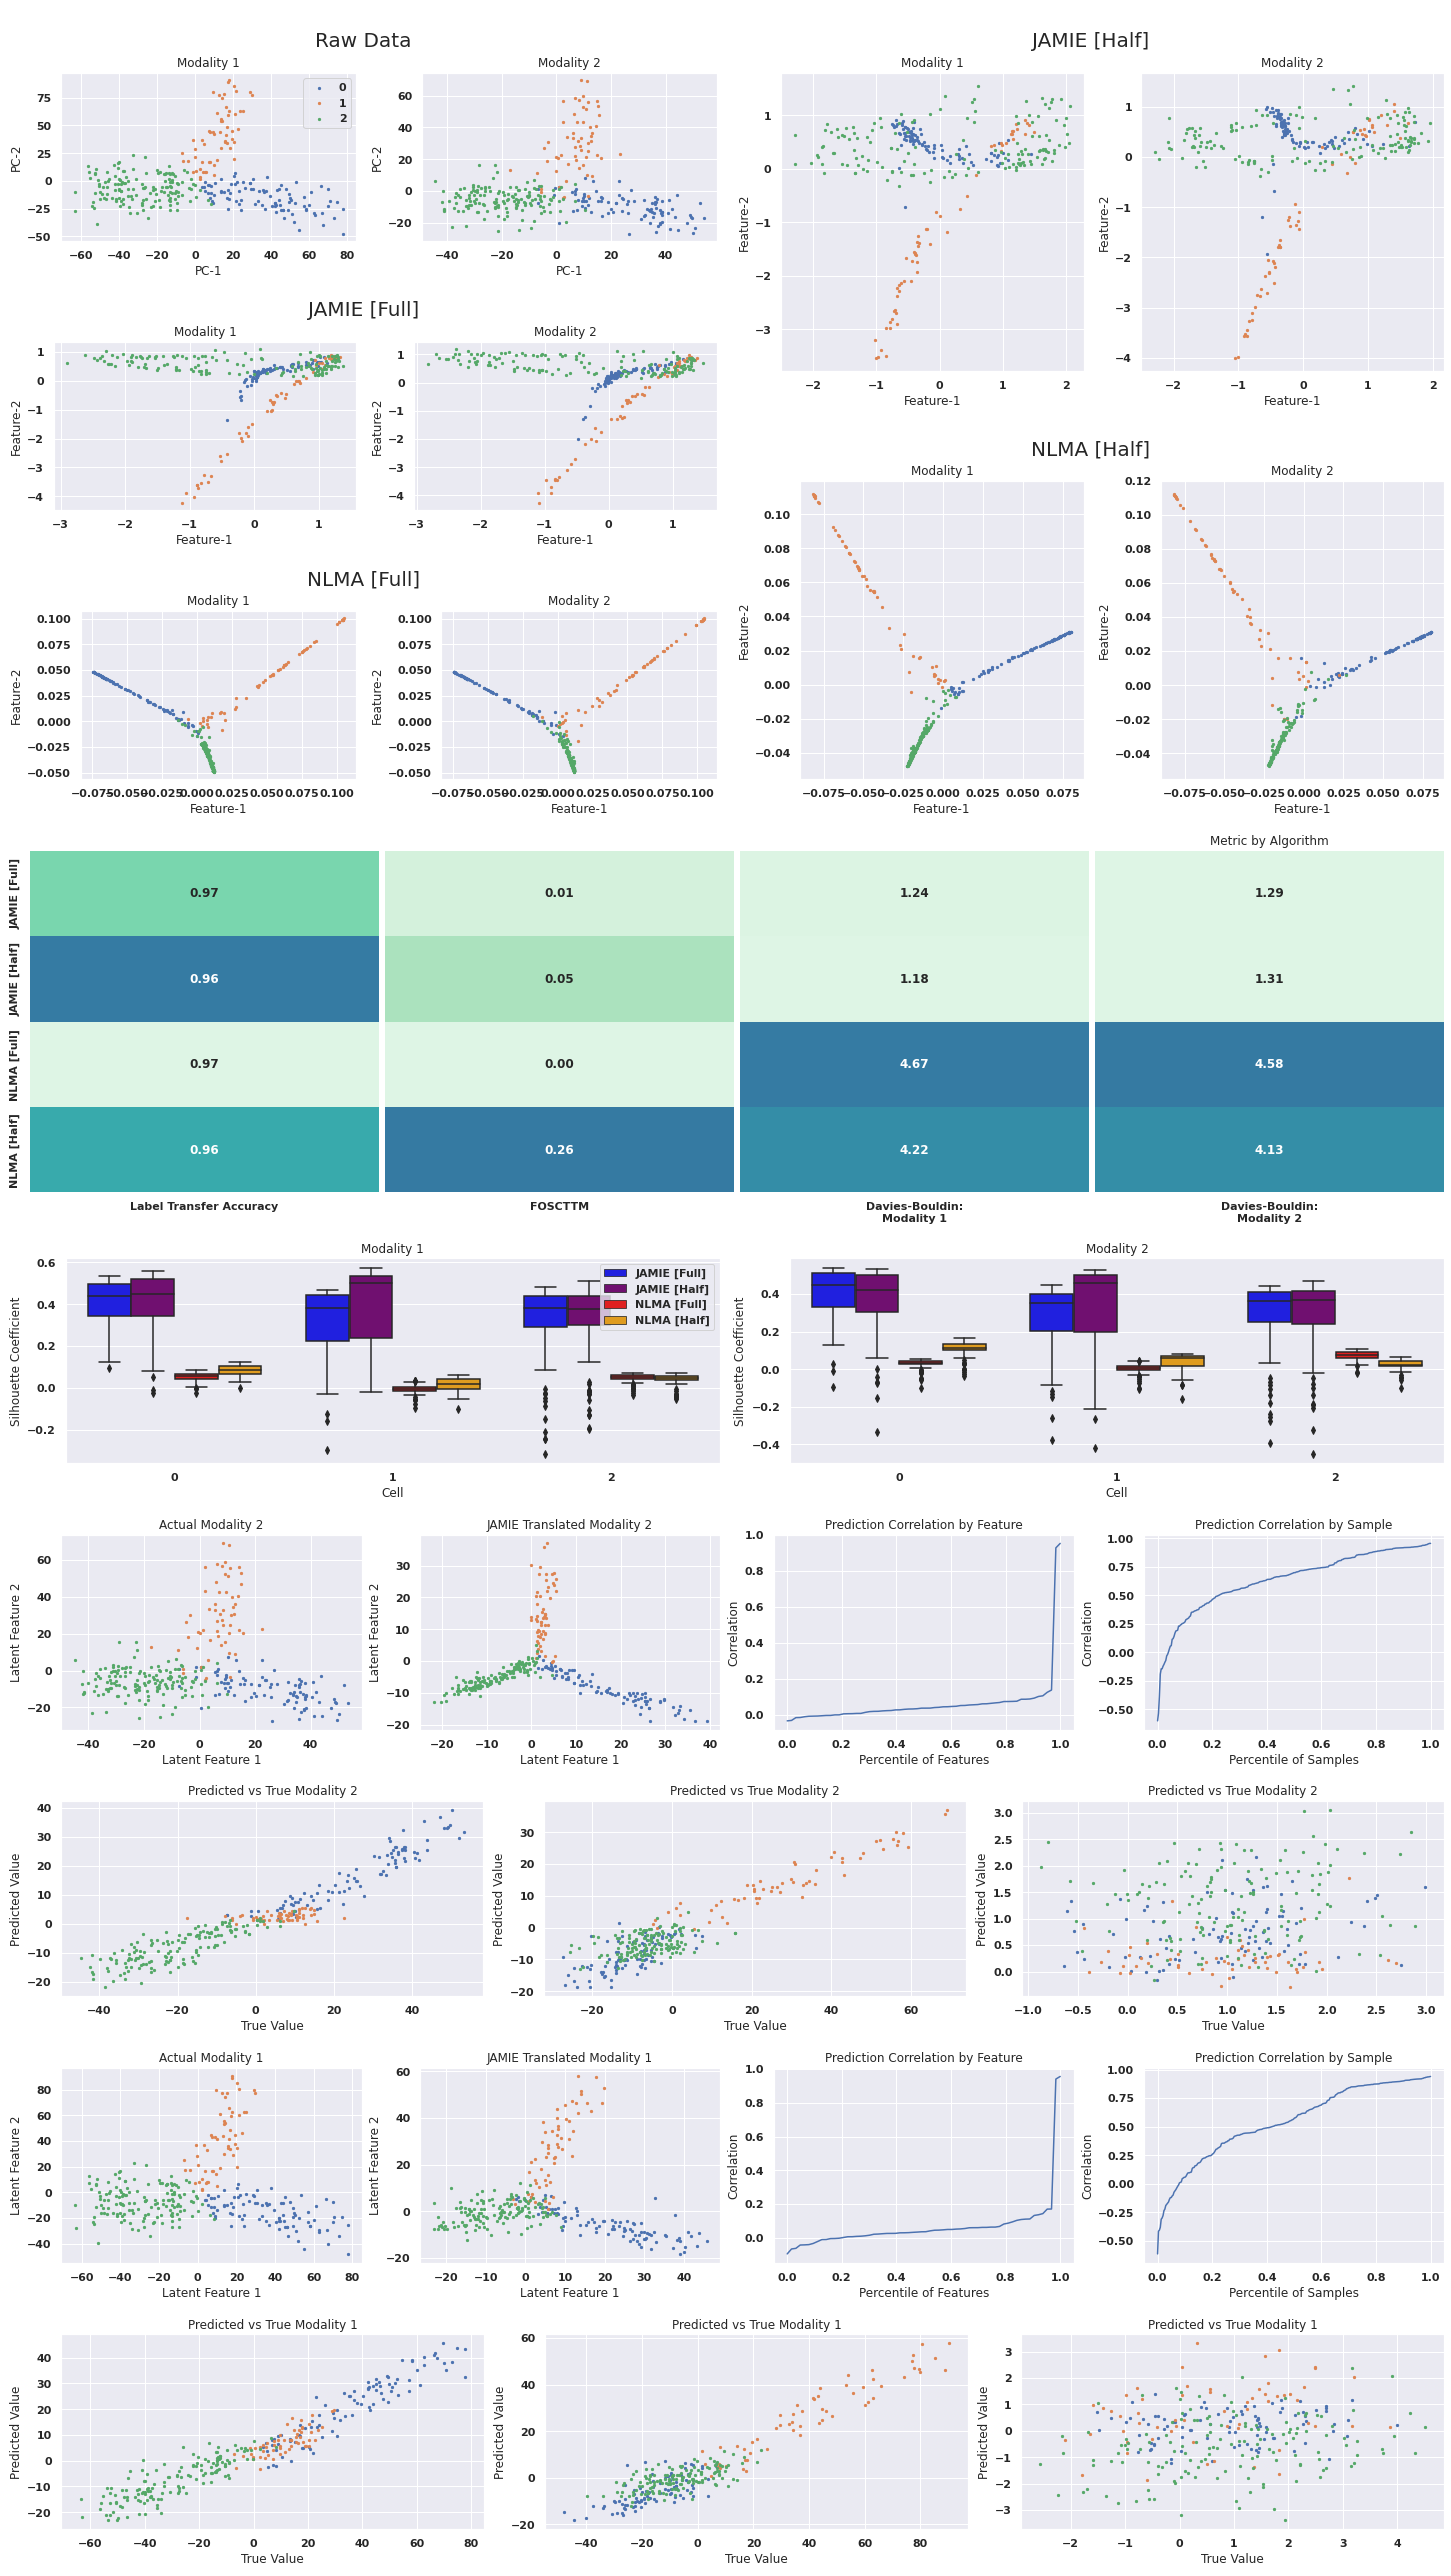

In [7]:
#%%capture --no-display
params = {
    'dataset_names': ['Modality 1', 'Modality 2'],
    'integrated_data': [cm_data, cm_data_half, nlma_data, nlma_data_half],
    'integrated_alg_names': ['JAMIE [Full]', 'JAMIE [Half]', 'NLMA [Full]', 'NLMA [Half]'],
    'colors': ['blue', 'purple', 'red', 'orange'],
    'alg_groups': [0, 1, 0, 1],
    'raw_data_group': 0,
    'integrated_rows': 1,
    'scale': 20,
    # 'integrated_use_pca': True,
    'skip_partial': True,
    'skip_nn': True,
    'skip_simple': True,
}
generate_figure(cm, dataset, labels, **params);